In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import spectrogram

from pyaw import utils
from pyaw.swarm import rotate_vector_by_quaternion

%load_ext watermark
%watermark -i -v -p matplotlib,numpy,pandas,scipy

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.27.0

matplotlib: 3.8.0
numpy     : 1.25.2
pandas    : 2.2.2
scipy     : 1.13.1



In [2]:
fps = [r'D:\cleo\master\pyaw\data\Swarm\vires\SW_OPER_MAGA_HR_1B\SW_OPER_MAGA_HR_1B_12728_20160301T012924_20160301T030258.pkl',
       r"\\Diskstation1\file_three\aw\swarm\vires\AHY9U3~9\SW_OPER_MAGA_HR_1B\aux_SW_OPER_MAGA_HR_1B_12728_20160301T012924_20160301T030258.pkl",
       r"\\Diskstation1\file_three\aw\swarm\vires\IGRF\SW_OPER_MAGA_HR_1B\IGRF_SW_OPER_MAGA_HR_1B_12728_20160301T012924_20160301T030258.pkl",
       r"\\Diskstation1\file_three\aw\swarm\vires\SW_EXPT_EFIA_TCT16\SW_EXPT_EFIA_TCT16_12728_20160301T012924_20160301T030258.pkl"]

In [3]:
df_b = pd.read_pickle(fps[0])
# df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

In [4]:
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius', 'q_NEC_CRF']]
# df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]

In [5]:
st = '20160311T064000'
et = '20160311T065000'
df_b_clip = df_b_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
# df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_e_clip = df_e_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

np.all(np.equal(df_b_clip.index.values, df_b_IGRF_clip.index.values))

True

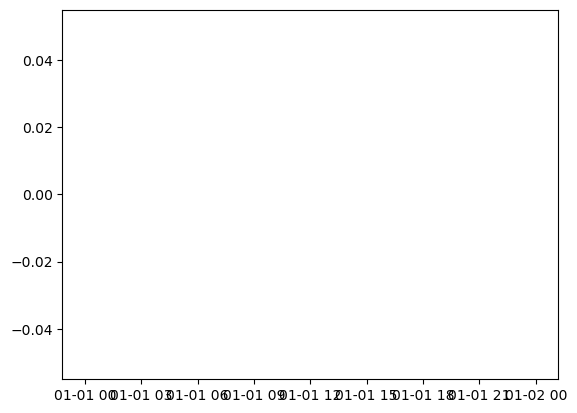

In [6]:
ehx = df_e_clip['Ehx'].values

plt.plot(df_e_clip.index.values, ehx)
plt.show()